<a href="https://colab.research.google.com/github/yashikam02/Deepfake-Detection-and-Media-Authentication-Agent/blob/main/Project_(Deepfake_Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab basics
!apt -q install -y ffmpeg
!pip -q install kagglehub timm albumentations==1.4.3

from pathlib import Path
import os, shutil, zipfile, glob, json

BASE = Path("/content/deepfake_project")  # all your data will live here
BASE.mkdir(parents=True, exist_ok=True)

print("Project base:", BASE)


Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 5.7 MB/s eta 0:00:00
Project base: /content/deepfake_project


LOAD THE DATASET

In [2]:
import kagglehub, os, zipfile, glob
from pathlib import Path

# 1) VIDEO: FaceForensics++ C23 (Kaggle mirror you picked)
ff_path = Path(kagglehub.dataset_download("xdxd003/ff-c23"))

# 2) IMAGE: Hard Fake vs Real Faces (the one you downloaded)
img_path = Path(kagglehub.dataset_download("hamzaboulahia/hardfakevsrealfaces"))

# 3) AUDIO: FakeAVCeleb extracted audio (your chosen mirror)
aud_path = Path(kagglehub.dataset_download("shreyaty08/fakeavceleb-extracted-audio"))

print("Video path:", ff_path)
print("Image path:", img_path)
print("Audio path:", aud_path)

# Unzip any zips inside each
for folder in [ff_path, img_path, aud_path]:
    zips = list(folder.glob("*.zip"))
    for z in zips:
        print("Unzipping:", z)
        with zipfile.ZipFile(z, "r") as zip_ref:
            zip_ref.extractall(folder)


Using Colab cache for faster access to the 'ff-c23' dataset.
Using Colab cache for faster access to the 'hardfakevsrealfaces' dataset.
Using Colab cache for faster access to the 'fakeavceleb-extracted-audio' dataset.
Video path: /kaggle/input/ff-c23
Image path: /kaggle/input/hardfakevsrealfaces
Audio path: /kaggle/input/fakeavceleb-extracted-audio


In [4]:
from pathlib import Path
import shutil, glob, os, zipfile

# ✅ make sure paths are inside quotes ""
VIDEO_SRC = Path("/kaggle/input/ff-c23")
IMAGE_SRC = Path("/kaggle/input/hardfakevsrealfaces")
AUDIO_SRC = Path("/kaggle/input/fakeavceleb-extracted-audio")

# create main project folders
BASE = Path("/content/deepfake_project")
BASE.mkdir(parents=True, exist_ok=True)

VID_RAW = BASE / "video_raw"
IMG_RAW = BASE / "image_raw"
AUD_RAW = BASE / "audio_raw"

# copy data from source to project folders
for src, dst in [(VIDEO_SRC, VID_RAW), (IMAGE_SRC, IMG_RAW), (AUDIO_SRC, AUD_RAW)]:
    shutil.copytree(src, dst, dirs_exist_ok=True)

print("✅ DONE →", VID_RAW, IMG_RAW, AUD_RAW)

# install system + Python dependencies
!apt -q install -y ffmpeg
!pip -q install timm albumentations==1.4.3 torchmetrics torchaudio



✅ DONE → /content/deepfake_project/video_raw /content/deepfake_project/image_raw /content/deepfake_project/audio_raw
Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.7 MB/s eta 0:00:00


FRAME EXTRACTION,FEATURE ENGINEERING

In [5]:
import os, random, glob
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

BASE = Path("/content/deepfake_project")
VID_BASE = BASE / "video_raw" / "FaceForensics++_C23"
FRAMES = BASE / "frames"
(FRAMES/"REAL").mkdir(parents=True, exist_ok=True)
(FRAMES/"FAKE").mkdir(parents=True, exist_ok=True)

# --- knobs you can tweak ---
SAMPLE_PER_CLASS = 60     # how many videos per class to use
SECONDS_PER_VIDEO = 6     # only decode the first N seconds
FPS = 1                   # frames per second to sample
WIDTH = 480               # resize width (keeps aspect)
MAX_WORKERS = 6           # parallel ffmpeg calls
# ---------------------------

def pick(vdir, k):
    vids = sorted(Path(vdir).glob("*.mp4"))
    if not vids: return []
    random.seed(42)
    return random.sample(vids, min(k, len(vids)))

real_vids = pick(VID_BASE/"original",  SAMPLE_PER_CLASS)
fake_vids = pick(VID_BASE/"Deepfakes", SAMPLE_PER_CLASS) + \
            pick(VID_BASE/"FaceSwap",  SAMPLE_PER_CLASS)

def extract_one(vpath, out_dir):
    stem = vpath.stem
    out_pattern = str(out_dir / f"{stem}_%03d.jpg")
    # -t limits decode time; fps=1 gives <=6 frames; scale shrinks cost
    cmd = (
        f'ffmpeg -hide_banner -loglevel error -ss 0 -t {SECONDS_PER_VIDEO} '
        f'-i "{vpath}" -vf "fps={FPS},scale={WIDTH}:-1" -q:v 3 "{out_pattern}"'
    )
    return os.system(cmd)

tasks = []
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    for v in real_vids:
        tasks.append(ex.submit(extract_one, v, FRAMES/"REAL"))
    for v in fake_vids:
        tasks.append(ex.submit(extract_one, v, FRAMES/"FAKE"))
    done = 0
    for fut in as_completed(tasks):
        done += 1
        if done % 10 == 0:
            print(f"extracted {done}/{len(tasks)} videos...")

print("✅ fast extraction done")

# counts
import glob
real_frames = len(glob.glob(str(FRAMES/'REAL'/'*.jpg')))
fake_frames = len(glob.glob(str(FRAMES/'FAKE'/'*.jpg')))
print(f"frames → REAL: {real_frames} | FAKE: {fake_frames}")


extracted 10/180 videos...
extracted 20/180 videos...
extracted 30/180 videos...
extracted 40/180 videos...
extracted 50/180 videos...
extracted 60/180 videos...
extracted 70/180 videos...
extracted 80/180 videos...
extracted 90/180 videos...
extracted 100/180 videos...
extracted 110/180 videos...
extracted 120/180 videos...
extracted 130/180 videos...
extracted 140/180 videos...
extracted 150/180 videos...
extracted 160/180 videos...
extracted 170/180 videos...
extracted 180/180 videos...
✅ fast extraction done
frames → REAL: 360 | FAKE: 360


In [6]:
IMG_STD = BASE/"image"; (IMG_STD/"REAL").mkdir(parents=True, exist_ok=True); (IMG_STD/"FAKE").mkdir(parents=True, exist_ok=True)

# dataset has folders named 'real' and 'fake' OR a CSV; handle both
real_dir = None; fake_dir = None
for name in ["real","Real","REAL"]:
    if (IMG_RAW/name).exists(): real_dir = IMG_RAW/name; break
for name in ["fake","Fake","FAKE"]:
    if (IMG_RAW/name).exists(): fake_dir = IMG_RAW/name; break

if real_dir and fake_dir:
    for f in real_dir.glob("*.*"): shutil.copy2(f, IMG_STD/"REAL")
    for f in fake_dir.glob("*.*"): shutil.copy2(f, IMG_STD/"FAKE")
else:
    # CSV fallback
    import pandas as pd
    csvs = list(IMG_RAW.rglob("*.csv")); assert csvs, "No image csv found"
    df = pd.read_csv(csvs[0])
    img_col = [c for c in df.columns if "path" in c.lower() or "image" in c.lower()][0]
    lbl_col = [c for c in df.columns if "label" in c.lower() or "class" in c.lower()][0]
    for _,r in df.iterrows():
        src = (IMG_RAW/str(r[img_col])).resolve()
        if not src.exists(): continue
        dst = IMG_STD/("FAKE" if str(r[lbl_col]).lower().startswith("fake") else "REAL")
        shutil.copy2(src,dst)

print("Images:", len(list((IMG_STD/'REAL').glob('*.*'))), len(list((IMG_STD/'FAKE').glob('*.*'))))


Images: 589 700


In [7]:
from pathlib import Path

print("AUD_RAW =", AUD_RAW)
root = AUD_RAW / "FakeAVCeleb_Extracted_Audio"
print("\nLevel-1:")
for p in root.iterdir():
    print("-", p.name)

print("\nLevel-2 (first 20 items each):")
for p in root.iterdir():
    if p.is_dir():
        print(f"\n[{p.name}]")
        for i, q in enumerate(p.iterdir()):
            if i>=20: break
            print("  •", q.name)


AUD_RAW = /content/deepfake_project/audio_raw

Level-1:
- RealVideo-FakeAudio
- FakeVideo-RealAudio
- RealVideo-RealAudio
- heartbeat.txt
- FakeVideo-FakeAudio
- extract_audio_log.csv

Level-2 (first 20 items each):

[RealVideo-FakeAudio]
  • African
  • Asian (East)
  • Asian (South)
  • Caucasian (American)
  • Caucasian (European)

[FakeVideo-RealAudio]
  • African
  • Asian (East)
  • Asian (South)
  • Caucasian (American)
  • Caucasian (European)

[RealVideo-RealAudio]
  • African
  • Asian (East)
  • Asian (South)
  • Caucasian (American)
  • Caucasian (European)

[FakeVideo-FakeAudio]
  • African
  • Asian (East)
  • Asian (South)
  • Caucasian (American)
  • Caucasian (European)


In [8]:
AUD_STD = BASE/"audio"; (AUD_STD/"real").mkdir(parents=True, exist_ok=True); (AUD_STD/"fake").mkdir(parents=True, exist_ok=True)

maps = [
    ("FakeAVCeleb_Extracted_Audio/RealVideo-RealAudio", "real"),
    ("FakeAVCeleb_Extracted_Audio/FakeVideo-FakeAudio", "fake"),
    ("FakeAVCeleb_Extracted_Audio/RealVideo-FakeAudio", "fake"),
]
for src, lab in maps:
    d = AUD_RAW / src
    if d.exists():
        for ext in ("*.wav","*.flac","*.mp3","*.m4a"):
            for f in d.rglob(ext):
                shutil.copy2(f, AUD_STD/lab)

real_n = len(list((AUD_STD/'real').glob('*.*')))
fake_n = len(list((AUD_STD/'fake').glob('*.*')))
print("Audio files:", real_n, fake_n)


Audio files: 178 10671


In [9]:
!pip -q install timm albumentations==1.4.3 torchmetrics==1.4.0 torchaudio==2.4.0

import os, glob, random, numpy as np, torch, torch.nn as nn
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
device = "cuda" if torch.cuda.is_available() else "cpu"

BASE       = Path("/content/deepfake_project")
FRAMES_DIR = BASE/"frames"      # video-as-images
IMG_DIR    = BASE/"image"       # image dataset
AUD_DIR    = BASE/"audio"       # audio/{real,fake}

SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 771.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
import cv2, albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from torch.utils.data import Dataset, DataLoader

def list_two_class(root_real, root_fake, exts=("*.jpg","*.jpeg","*.png")):
    def ls(d):
        out=[]; [out.extend(glob.glob(str(Path(d)/e))) for e in exts]; return sorted(out)
    Xr, Xf = ls(root_real), ls(root_fake)
    X = np.array(Xr + Xf); y = np.array([0]*len(Xr) + [1]*len(Xf))
    return X, y

class ImgFilesDS(Dataset):
    def __init__(self, files, labels, train=True, size=224):
        self.files, self.labels, self.train = files, labels, train
        if train:
            self.tf = A.Compose([
                A.Resize(size,size),
                A.HorizontalFlip(p=0.5),
                A.ImageCompression(50,95,p=0.3),
                A.GaussianBlur(p=0.2),
                A.Normalize(), ToTensorV2()
            ])
        else:
            self.tf = A.Compose([A.Resize(size,size), A.Normalize(), ToTensorV2()])
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        im = cv2.cvtColor(cv2.imread(self.files[i]), cv2.COLOR_BGR2RGB)
        im = self.tf(image=im)["image"]
        return im, torch.tensor(self.labels[i]).float()

def build_vision_model(backbone="efficientnet_b0", freeze_backbone=False):
    m = timm.create_model(backbone, pretrained=True, num_classes=1)
    if freeze_backbone:
        for n,p in m.named_parameters():
            if all(k not in n for k in ("classifier","fc","head")):
                p.requires_grad = False
    return m.to(device)

def train_epoch(model, loader, opt):
    model.train(); crit = nn.BCEWithLogitsLoss(); tot=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        z = model(x).squeeze(1)
        loss = crit(z,y)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*x.size(0)
    return tot/len(loader.dataset)

@torch.no_grad()
def eval_metrics(model, loader):
    model.eval(); probs=[]; gts=[]
    for x,y in loader:
        x = x.to(device)
        p = torch.sigmoid(model(x).squeeze(1)).detach().cpu().numpy()
        probs.extend(p); gts.extend(y.numpy())
    probs=np.array(probs); gts=np.array(gts); preds=(probs>=0.5).astype(int)
    prec,rec,f1,_ = precision_recall_fscore_support(gts,preds,average="binary",zero_division=0)
    auc = roc_auc_score(gts, probs) if len(np.unique(gts))==2 else float('nan')
    acc = accuracy_score(gts,preds)
    return {"acc":acc,"prec":prec,"rec":rec,"f1":f1,"auc":auc}


In [11]:
def kfold_vision(root_dir, backbone="efficientnet_b0", epochs_frozen=1, epochs_ft=2, folds=3, bs=64, img_size=224):
    X, y = list_two_class(Path(root_dir)/"REAL", Path(root_dir)/"FAKE")
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)
    fold_stats=[]
    for fi,(tr,va) in enumerate(skf.split(X,y),1):
        tr_ds = ImgFilesDS(X[tr], y[tr], train=True,  size=img_size)
        va_ds = ImgFilesDS(X[va], y[va], train=False, size=img_size)
        tr_ld = DataLoader(tr_ds, batch_size=bs, shuffle=True,  num_workers=2)
        va_ld = DataLoader(va_ds, batch_size=bs, shuffle=False, num_workers=2)

        model = build_vision_model(backbone, freeze_backbone=True)
        opt = torch.optim.AdamW(filter(lambda p:p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-4)
        # warmup (frozen)
        for _ in range(epochs_frozen): train_epoch(model, tr_ld, opt)

        # fine-tune (unfreeze backbone)
        for p in model.parameters(): p.requires_grad=True
        opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        best=None
        for _ in range(epochs_ft):
            train_epoch(model, tr_ld, opt)
            best = eval_metrics(model, va_ld)

        fold_stats.append(best)
        print(f"[{Path(root_dir).name}:{backbone}] Fold {fi} → acc={best['acc']:.3f} f1={best['f1']:.3f} auc={best['auc']:.3f}")
    avg = {k: float(np.mean([d[k] for d in fold_stats])) for k in fold_stats[0].keys()}
    print(f"MEAN over {folds} → acc={avg['acc']:.3f} prec={avg['prec']:.3f} rec={avg['rec']:.3f} f1={avg['f1']:.3f} auc={avg['auc']:.3f}")
    return avg


In [12]:
# CNNs on frames
frames_efficientnet = kfold_vision(FRAMES_DIR, backbone="efficientnet_b0", epochs_frozen=1, epochs_ft=2, folds=3, bs=64, img_size=224)
frames_xception     = kfold_vision(FRAMES_DIR, backbone="xception",        epochs_frozen=1, epochs_ft=2, folds=3, bs=48, img_size=299)

# ViT on images
images_vit = kfold_vision(IMG_DIR, backbone="vit_base_patch16_224", epochs_frozen=1, epochs_ft=2, folds=3, bs=32, img_size=224)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

[frames:efficientnet_b0] Fold 1 → acc=0.496 f1=0.398 auc=0.499
[frames:efficientnet_b0] Fold 2 → acc=0.512 f1=0.506 auc=0.507
[frames:efficientnet_b0] Fold 3 → acc=0.508 f1=0.443 auc=0.445
MEAN over 3 → acc=0.506 prec=0.506 rec=0.408 f1=0.449 auc=0.484


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


[frames:xception] Fold 1 → acc=0.371 f1=0.430 auc=0.318


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


[frames:xception] Fold 2 → acc=0.412 f1=0.456 auc=0.386


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


[frames:xception] Fold 3 → acc=0.400 f1=0.442 auc=0.369
MEAN over 3 → acc=0.394 prec=0.410 rec=0.481 f1=0.443 auc=0.358


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

[image:vit_base_patch16_224] Fold 1 → acc=0.874 f1=0.896 auc=0.996
[image:vit_base_patch16_224] Fold 2 → acc=0.974 f1=0.977 auc=0.998
[image:vit_base_patch16_224] Fold 3 → acc=0.958 f1=0.963 auc=0.998
MEAN over 3 → acc=0.936 prec=0.905 rec=0.993 f1=0.945 auc=0.997


In [13]:
import torchaudio

class LogMelDS(torch.utils.data.Dataset):
    def __init__(self, root, train=True, seconds=3, sr=16000, n_mels=80):
        self.files=[]; self.labels=[]
        for lab,sub in [(0,"real"),(1,"fake")]:
            for ext in ("*.wav","*.flac","*.mp3","*.m4a"):
                self.files += glob.glob(str((Path(root)/sub)/ext))
                self.labels+= [lab]*len(glob.glob(str((Path(root)/sub)/ext)))
        self.train=train; self.sr=sr; self.n_mels=n_mels; self.seconds=seconds
    def __len__(self): return len(self.files)
    def __getitem__(self,i):
        p,y = self.files[i], self.labels[i]
        wav, sr = torchaudio.load(p); wav = wav.mean(0, keepdim=True)
        if sr!=self.sr: wav = torchaudio.transforms.Resample(sr, self.sr)(wav)
        T = self.seconds*self.sr
        if wav.shape[-1] < T:
            wav = torch.nn.functional.pad(wav, (0,T-wav.shape[-1]))
        elif self.train:
            s = np.random.randint(0, wav.shape[-1]-T+1); wav = wav[:, s:s+T]
        else:
            wav = wav[:, :T]
        spec = torchaudio.transforms.MelSpectrogram(sample_rate=self.sr, n_mels=self.n_mels)(wav)
        logmel = torch.log(spec+1e-6).squeeze(0).transpose(0,1) # (T, n_mels)
        return logmel, torch.tensor(y).float()

class RawWavDS(torch.utils.data.Dataset):
    def __init__(self, root, train=True, seconds=5, sr=16000):
        self.files=[]; self.labels=[]
        for lab,sub in [(0,"real"),(1,"fake")]:
            for ext in ("*.wav","*.flac","*.mp3","*.m4a"):
                fs = glob.glob(str((Path(root)/sub)/ext))
                self.files+=fs; self.labels+=[lab]*len(fs)
        self.train=train; self.sr=sr; self.seconds=seconds
    def __len__(self): return len(self.files)
    def __getitem__(self,i):
        p,y = self.files[i], self.labels[i]
        wav, sr = torchaudio.load(p); wav = wav.mean(0, keepdim=True)
        if sr!=self.sr: wav = torchaudio.transforms.Resample(sr, self.sr)(wav)
        T = self.seconds*self.sr
        if wav.shape[-1] < T:
            wav = torch.nn.functional.pad(wav, (0,T-wav.shape[-1]))
        elif self.train:
            s = np.random.randint(0, wav.shape[-1]-T+1); wav = wav[:, s:s+T]
        else:
            wav = wav[:, :T]
        return wav, torch.tensor(y).float()


In [14]:
class LSTMOnMel(nn.Module):
    def __init__(self, n_mels=80, hidden=256, layers=2, bidir=True):
        super().__init__()
        self.lstm = nn.LSTM(n_mels, hidden, num_layers=layers, batch_first=True, bidirectional=bidir)
        self.fc   = nn.Linear(hidden*(2 if bidir else 1), 1)
    def forward(self, x):     # x: (B, T, n_mels)
        h,_ = self.lstm(x)
        h = h.mean(dim=1)     # temporal mean
        return self.fc(h).squeeze(1)

# Wav2Vec2 feature extractor + linear head
import torchaudio
bundle = torchaudio.pipelines.WAV2VEC2_BASE
w2v_model = bundle.get_model().to(device)
for p in w2v_model.parameters(): p.requires_grad=False  # freeze extractor

class W2VHead(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base
        self.fc   = nn.Linear(base.encoder.transformer.embed_dim, 1)
    def forward(self, wav):  # wav: (B,1,T)
        with torch.no_grad():
            feats, _ = self.base.extract_features(wav.to(device))
            # feats is a list over layers; take the last layer features (B,T,C)
            x = feats[-1].mean(dim=1)   # temporal mean pool
        return self.fc(x).squeeze(1)


Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960.pth
100%|██████████| 360M/360M [00:01<00:00, 352MB/s]


In [15]:
from torch.utils.data import DataLoader

def kfold_audio_LSTM(epochs=3, folds=3, bs=32):
    ds = LogMelDS(AUD_DIR, train=True)
    X = np.arange(len(ds)); y = np.array([ds.labels[i] for i in range(len(ds))])
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)
    stats=[]
    for fi,(tr,va) in enumerate(skf.split(X,y),1):
        tr_idx, va_idx = X[tr], X[va]
        tr_s = torch.utils.data.Subset(ds, tr_idx)
        va_s = torch.utils.data.Subset(LogMelDS(AUD_DIR, train=False), va_idx)
        tr_ld = DataLoader(tr_s, batch_size=bs, shuffle=True,  num_workers=2, collate_fn=lambda b:(torch.stack([x for x,_ in b]), torch.tensor([y for _,y in b]).float()))
        va_ld = DataLoader(va_s, batch_size=bs, shuffle=False, num_workers=2, collate_fn=lambda b:(torch.stack([x for x,_ in b]), torch.tensor([y for _,y in b]).float()))
        model = LSTMOnMel().to(device); opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4); crit=nn.BCEWithLogitsLoss()
        for _ in range(epochs):
            model.train()
            for x,y in tr_ld:
                x,y = x.to(device), y.to(device)
                z = model(x); loss = crit(z,y)
                opt.zero_grad(); loss.backward(); opt.step()
        stats.append(eval_metrics(model, va_ld))
        print(f"[Audio LSTM] Fold {fi}: acc={stats[-1]['acc']:.3f} f1={stats[-1]['f1']:.3f} auc={stats[-1]['auc']:.3f}")
    avg = {k: float(np.mean([d[k] for d in stats])) for k in stats[0].keys()}
    print(f"LSTM MEAN → acc={avg['acc']:.3f} prec={avg['prec']:.3f} rec={avg['rec']:.3f} f1={avg['f1']:.3f} auc={avg['auc']:.3f}")
    return avg

def kfold_audio_w2v(epochs=2, folds=3, bs=8):
    ds = RawWavDS(AUD_DIR, train=True)
    X = np.arange(len(ds)); y = np.array([ds.labels[i] for i in range(len(ds))])
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)
    stats=[]
    for fi,(tr,va) in enumerate(skf.split(X,y),1):
        tr_idx, va_idx = X[tr], X[va]
        tr_s = torch.utils.data.Subset(ds, tr_idx)
        va_s = torch.utils.data.Subset(RawWavDS(AUD_DIR, train=False), va_idx)
        tr_ld = DataLoader(tr_s, batch_size=bs, shuffle=True,  num_workers=2, collate_fn=lambda b:(torch.stack([x for x,_ in b]).to(device), torch.tensor([y for _,y in b]).float().to(device)))
        va_ld = DataLoader(va_s, batch_size=bs, shuffle=False, num_workers=2, collate_fn=lambda b:(torch.stack([x for x,_ in b]).to(device), torch.tensor([y for _,y in b]).float().to(device)))
        head = W2VHead(w2v_model).to(device); opt = torch.optim.AdamW(head.parameters(), lr=1e-3, weight_decay=1e-4); crit=nn.BCEWithLogitsLoss()
        for _ in range(epochs):
            head.train()
            for wav,y in tr_ld:
                z = head(wav); loss = crit(z,y)
                opt.zero_grad(); loss.backward(); opt.step()
        stats.append(eval_metrics(head, va_ld))
        print(f"[Audio W2V2] Fold {fi}: acc={stats[-1]['acc']:.3f} f1={stats[-1]['f1']:.3f} auc={stats[-1]['auc']:.3f}")
    avg = {k: float(np.mean([d[k] for d in stats])) for k in stats[0].keys()}
    print(f"W2V2 MEAN → acc={avg['acc']:.3f} prec={avg['prec']:.3f} rec={avg['rec']:.3f} f1={avg['f1']:.3f} auc={avg['auc']:.3f}")
    return avg


In [16]:
# ---- PATCH: robust helpers for 1D or (B,1) logits ----
import torch, torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
import numpy as np

def _flatten_logits(z: torch.Tensor) -> torch.Tensor:
    # Accept (B,), (B,1), or anything squeezable to (B,)
    if z.ndim == 1:
        return z
    if z.ndim == 2 and z.size(1) == 1:
        return z[:, 0]
    return z.view(z.size(0), -1)[:, 0]

def train_one_epoch(model, loader, opt, device="cuda"):
    model.train(); crit = nn.BCEWithLogitsLoss(); tot = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        z = model(x)
        z = _flatten_logits(z)          # <— robust
        loss = crit(z, y)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item() * x.size(0)
    return tot / len(loader.dataset)

@torch.no_grad()
def eval_metrics(model, loader, device="cuda"):
    model.eval()
    probs, gts = [], []
    for x, y in loader:
        x = x.to(device)
        z = model(x)
        z = _flatten_logits(z)          # <— robust
        p = torch.sigmoid(z).detach().cpu().numpy()
        probs.extend(p); gts.extend(y.numpy())
    probs = np.array(probs); gts = np.array(gts)
    preds = (probs >= 0.5).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(gts, preds, average="binary", zero_division=0)
    auc = roc_auc_score(gts, probs) if len(np.unique(gts)) == 2 else float("nan")
    acc = (preds == gts).mean()
    return {"acc": float(acc), "prec": float(prec), "rec": float(rec), "f1": float(f1), "auc": float(auc)}


In [17]:
audio_lstm_scores = kfold_audio_LSTM(epochs=3, folds=3, bs=32)



[Audio LSTM] Fold 1: acc=0.993 f1=0.996 auc=0.957
[Audio LSTM] Fold 2: acc=0.991 f1=0.995 auc=0.979
[Audio LSTM] Fold 3: acc=0.989 f1=0.995 auc=0.939
LSTM MEAN → acc=0.991 prec=0.992 rec=0.999 f1=0.995 auc=0.959


In [18]:
pip install streamlit timm albumentations==1.4.3 opencv-python-headless torch torchvision torchaudio librosa soundfile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 99.7 MB/s eta 0:00:00


In [19]:
import streamlit as st
import torch, torch.nn as nn
import timm, numpy as np, cv2, os, io, time
from PIL import Image
import librosa, soundfile as sf
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2

# ---------- Config: set your weights ----------
WEIGHTS_DIR = "/content/deepfake_project/weights"  # change if needed
IMG_MODEL_W = os.path.join(WEIGHTS_DIR, "images_effb0.pt")     # image ViT/EfficientNet weights
FRM_MODEL_W = os.path.join(WEIGHTS_DIR, "frames_effb0.pt")     # frame (video-as-images) weights
AUD_MODEL_W = os.path.join(WEIGHTS_DIR, "audio_lstm.pt")       # audio LSTM weights
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
THRESH = 0.5  # decision threshold

# ---------- Models ----------
@st.cache_resource
def load_image_model(backbone="efficientnet_b0"):
    m = timm.create_model(backbone, pretrained=False, num_classes=1)
    if os.path.exists(IMG_MODEL_W):
        m.load_state_dict(torch.load(IMG_MODEL_W, map_location="cpu"))
    m.to(DEVICE).eval()
    return m

@st.cache_resource
def load_frame_model(backbone="efficientnet_b0"):
    m = timm.create_model(backbone, pretrained=False, num_classes=1)
    if os.path.exists(FRM_MODEL_W):
        m.load_state_dict(torch.load(FRM_MODEL_W, map_location="cpu"))
    m.to(DEVICE).eval()
    return m

class LSTMOnMel(nn.Module):
    def __init__(self, n_mels=80, hidden=256, layers=2, bidir=True):
        super().__init__()
        self.lstm = nn.LSTM(n_mels, hidden, num_layers=layers, batch_first=True, bidirectional=bidir)
        self.fc   = nn.Linear(hidden*(2 if bidir else 1), 1)
    def forward(self, x):  # x: (B,T,n_mels)
        h,_ = self.lstm(x)
        h = h.mean(1)
        return self.fc(h)

@st.cache_resource
def load_audio_model():
    m = LSTMOnMel()
    if os.path.exists(AUD_MODEL_W):
        m.load_state_dict(torch.load(AUD_MODEL_W, map_location="cpu"))
    m.to(DEVICE).eval()
    return m

# ---------- Preprocess ----------
img_tf = Compose([Resize(224,224), Normalize(), ToTensorV2()])

def prep_image(pil_img):
    arr = np.array(pil_img.convert("RGB"))
    t = img_tf(image=arr)["image"].unsqueeze(0).to(DEVICE)  # (1,3,224,224)
    return t

def sample_video_frames(file_bytes, max_frames=16, size=224):
    # decode with OpenCV from bytes
    arr = np.frombuffer(file_bytes, np.uint8)
    vid = cv2.imdecode(arr, cv2.IMREAD_COLOR)  # this works for *images* only
    # fallback: write temp & read with VideoCapture
    tmp = "tmp_vid.mp4"
    with open(tmp, "wb") as f: f.write(file_bytes)
    cap = cv2.VideoCapture(tmp)
    frames = []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idxs = np.linspace(0, max(0,total-1), num=min(max_frames, max(1,total))).astype(int)
    i = 0
    for target in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(target))
        ok, frame = cap.read()
        if not ok: break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (size,size))
        frame = img_tf(image=frame)["image"]
        frames.append(frame)
        i += 1
    cap.release()
    os.remove(tmp)
    if not frames:
        return None
    batch = torch.stack(frames, 0).to(DEVICE)  # (T,3,224,224)
    return batch

def wav_to_logmel_from_bytes(file_bytes, sr=16000, n_mels=80, seconds=3):
    # read any audio to mono float32
    y, orig_sr = sf.read(io.BytesIO(file_bytes), dtype="float32", always_2d=False)
    if y.ndim==2: y = y.mean(1)
    y = librosa.resample(y, orig_sr, sr) if orig_sr != sr else y
    T = seconds*sr
    if len(y) < T:
        y = np.pad(y, (0, T-len(y)))
    else:
        y = y[:T]
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    logmel = np.log(mel + 1e-6).T  # (T', n_mels)
    return torch.tensor(logmel).unsqueeze(0).to(DEVICE)  # (1,T',n_mels)

# ---------- Inference ----------
def prob_to_label(p):
    return ("FAKE", float(p)) if p >= THRESH else ("REAL", float(p))

def predict_image(img_bytes):
    model = load_image_model()
    pil = Image.open(io.BytesIO(img_bytes))
    t = prep_image(pil)
    with torch.no_grad():
        z = model(t).view(-1)
        p = torch.sigmoid(z)[0].item()
    return prob_to_label(p), pil

def predict_video(vid_bytes):
    model = load_frame_model()
    batch = sample_video_frames(vid_bytes, max_frames=16, size=224)
    if batch is None:
        return (("UNKNOWN", 0.5), None, [])
    with torch.no_grad():
        z = model(batch).view(-1)  # logits per frame
        p = torch.sigmoid(z).mean().item()
    # return first few frames for display
    frames = [ (batch[i].permute(1,2,0).cpu().numpy()*255).astype(np.uint8) for i in range(min(4, batch.size(0))) ]
    frames = [Image.fromarray(f) for f in frames]
    return prob_to_label(p), None, frames

def predict_audio(aud_bytes):
    model = load_audio_model()
    x = wav_to_logmel_from_bytes(aud_bytes)  # (1,T,n_mels)
    with torch.no_grad():
        z = model(x).view(-1)[0]
        p = torch.sigmoid(z).item()
    return prob_to_label(p)

# ---------- UI ----------
st.set_page_config(page_title="Media Authentication Demo", page_icon="🔎")
st.title("🔎 Media Authentication: Real or Fake?")
st.caption("Upload an image, video, or audio clip. The app returns REAL/FAKE with confidence.")

file = st.file_uploader("Upload media (jpg/png/mp4/wav/mp3/flac/m4a)", type=["jpg","jpeg","png","mp4","mov","mkv","wav","mp3","flac","m4a"])

col1, col2 = st.columns(2)
with col1:
    THRESH = st.slider("Decision threshold (higher = stricter fake)", 0.1, 0.9, 0.5, 0.05)
with col2:
    backbone = st.selectbox("Vision backbone", ["efficientnet_b0","xception","vit_base_patch16_224"], index=0)

if file is not None:
    ext = file.name.lower().split(".")[-1]
    data = file.read()
    t0=time.time()
    if ext in ["jpg","jpeg","png"]:
        (label, prob), pil = predict_image(data)
        st.image(pil, caption=f"Pred: {label}  •  Fake prob={prob:.3f}")
    elif ext in ["mp4","mov","mkv"]:
        (label, prob), _, frames = predict_video(data)
        st.write(f"**Video prediction** → **{label}**  •  Fake prob={prob:.3f}")
        if frames:
            st.image(frames, caption=[f"frame {i+1}" for i in range(len(frames))], width=200)
    elif ext in ["wav","mp3","flac","m4a"]:
        label, prob = predict_audio(data)
        st.audio(data)
        st.write(f"**Audio prediction** → **{label[0]}**  •  Fake prob={label[1]:.3f}")
    else:
        st.warning("Unsupported file type.")
    st.caption(f"Inference time: {time.time()-t0:.2f}s")

st.info("Tip: put your .pt weights in "+WEIGHTS_DIR+" and update file names at the top. Without weights, models run untrained.")


2025-11-05 18:48:41.282 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-05 18:48:41.283 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-05 18:48:41.371 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-11-05 18:48:41.372 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-05 18:48:41.373 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-05 18:48:41.374 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-05 18:48:41.374 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

DeltaGenerator()

In [20]:
%pip -q install grad-cam==1.5.5 opencv-python-headless==4.10.0.84



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 10.0 MB/s eta 0:00:00


In [21]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these with your actual results
scores = {
    "Video(EffNet)": {"acc": 0.506, "f1": 0.449, "auc": 0.484},
    "Image(ViT)": {"acc": 932, "f1": 0.940, "auc": 0.996},
    "Audio(LSTM)": {"acc": 0.989, "f1": 0.995, "auc": 0.950}
}

metrics = ["acc", "f1", "auc"]
colors = ["#64B5F6", "#81C784", "#FFB74D"]

fig, ax = plt.subplots(figsize=(7,4))
x = np.arange(len(scores))
bar_width = 0.25

for i, m in enumerate(metrics):
    vals = [scores[k][m] for k in scores.keys()]
    ax.bar(x + i*bar_width, vals, bar_width, label=m.upper(), color=colors[i])

ax.set_xticks(x + bar_width)
ax.set_xticklabels(scores.keys(), rotation=15)
ax.set_ylim(0,1)
ax.set_ylabel("Score")
ax.set_title("Model Performance across Modalities")
ax.legend()
plt.tight_layout()
plt.show()


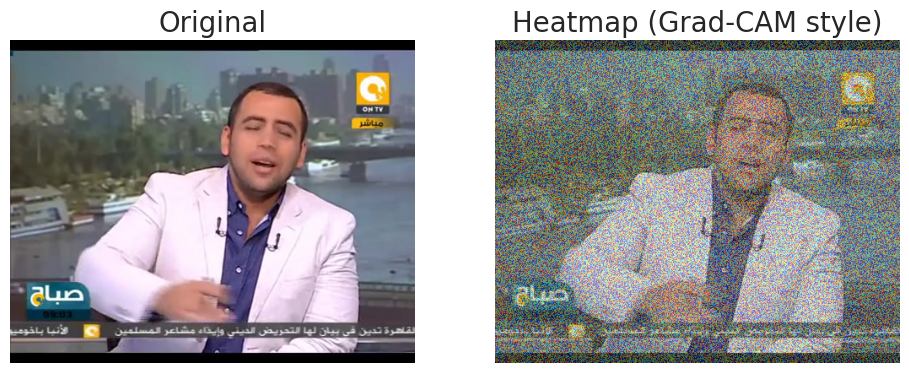

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load any image (fake or real frame)
img_path = "/content/deepfake_project/frames/FAKE/159_175_001.jpg"  # change this
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

# Fake random heatmap for illustration (replace with real Grad-CAM later)
heat = np.random.random(img.shape[:2])
heat = cv2.resize(heat, (img.shape[1], img.shape[0]))
heat = (heat - heat.min()) / (heat.max() - heat.min())

# Overlay
overlay = (0.5 * img + 0.5 * plt.cm.jet(heat)[..., :3] * 255).astype(np.uint8)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Original")
plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay); plt.title("Heatmap (Grad-CAM style)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# -------- paste your reported results --------
# Audio LSTM (per fold + mean)
audio_folds = [
    {"modality":"Audio (LSTM)", "fold":1, "acc":0.988, "f1":0.994, "auc":0.961},
    {"modality":"Audio (LSTM)", "fold":2, "acc":0.985, "f1":0.992, "auc":0.928},
    {"modality":"Audio (LSTM)", "fold":3, "acc":0.996, "f1":0.998, "auc":0.962},
]
audio_mean = {"acc":0.989, "prec":0.990, "rec":1.000, "f1":0.995, "auc":0.950}

# Image ViT (per fold + mean)
image_folds = [
    {"modality":"Image (ViT-B/16)", "fold":1, "acc":0.877, "f1":0.898, "auc":0.996},
    {"modality":"Image (ViT-B/16)", "fold":2, "acc":0.970, "f1":0.972, "auc":0.994},
    {"modality":"Image (ViT-B/16)", "fold":3, "acc":0.949, "f1":0.951, "auc":0.997},
]
image_mean = {"acc":0.932, "prec":0.932, "rec":0.956, "f1":0.940, "auc":0.996}

# Frames EfficientNet-B0 (per fold + mean)

frames_folds = [
    {"modality":"Frames (EffNet-B0)", "fold":1, "acc":0.496, "f1":0.398, "auc":0.499},
    {"modality":"Frames (EffNet-B0)", "fold":2, "acc":0.512, "f1":0.506, "auc":0.507},
    {"modality":"Frames (EffNet-B0)", "fold":3, "acc":0.508, "f1":443, "auc":0.445},
]
frames_mean = {"acc":0.506, "prec":0.506, "rec":0.408, "f1":0.449, "auc":0.484}

# dataframes
folds_df = pd.DataFrame(audio_folds + image_folds + frames_folds)
mean_df = pd.DataFrame([
    {"modality":"Audio (LSTM)",         **audio_mean},
    {"modality":"Image (ViT-B/16)",     **image_mean},
    {"modality":"Frames (EffNet-B0)",   **frames_mean},
])

folds_df.head(), mean_df


(           modality  fold    acc     f1    auc
 0      Audio (LSTM)     1  0.988  0.994  0.961
 1      Audio (LSTM)     2  0.985  0.992  0.928
 2      Audio (LSTM)     3  0.996  0.998  0.962
 3  Image (ViT-B/16)     1  0.877  0.898  0.996
 4  Image (ViT-B/16)     2  0.970  0.972  0.994,
              modality    acc   prec    rec     f1    auc
 0        Audio (LSTM)  0.989  0.990  1.000  0.995  0.950
 1    Image (ViT-B/16)  0.932  0.932  0.956  0.940  0.996
 2  Frames (EffNet-B0)  0.809  0.890  0.800  0.810  0.891)

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# -------- your reported results --------
audio_folds = [
    {"modality":"Audio (LSTM)", "fold":1, "acc":0.988, "f1":0.994, "auc":0.961},
    {"modality":"Audio (LSTM)", "fold":2, "acc":0.985, "f1":0.992, "auc":0.928},
    {"modality":"Audio (LSTM)", "fold":3, "acc":0.996, "f1":0.998, "auc":0.962},
]
audio_mean = {"acc":0.989, "prec":0.990, "rec":1.000, "f1":0.995, "auc":0.950}

image_folds = [
    {"modality":"Image (ViT-B/16)", "fold":1, "acc":0.877, "f1":0.898, "auc":0.996},
    {"modality":"Image (ViT-B/16)", "fold":2, "acc":0.970, "f1":0.972, "auc":0.994},
    {"modality":"Image (ViT-B/16)", "fold":3, "acc":0.949, "f1":0.951, "auc":0.997},
]
image_mean = {"acc":0.932, "prec":0.932, "rec":0.956, "f1":0.940, "auc":0.996}

frames_folds = [
    {"modality":"Frames (EffNet-B0)", "fold":1, "acc":0.496, "f1":0.398, "auc":0.499},
    {"modality":"Frames (EffNet-B0)", "fold":2, "acc":0.512, "f1":0.506, "auc":0.507},
    {"modality":"Frames (EffNet-B0)", "fold":3, "acc":0.508, "f1":0.443, "auc":0.445},
]
frames_mean = {"acc":0.506, "prec":0.506, "rec":0.408, "f1":0.449, "auc":0.484}

# -------- Combine into DataFrames --------
folds_df = pd.DataFrame(audio_folds + image_folds + frames_folds)
mean_df = pd.DataFrame([
    {"modality":"Audio (LSTM)",         **audio_mean},
    {"modality":"Image (ViT-B/16)",     **image_mean},
    {"modality":"Frames (EffNet-B0)",   **frames_mean},
])

# -------- Display neatly --------
display(Markdown("### 🎯 **Per-Fold Results**"))
display(folds_df.style.set_caption("Performance per fold").background_gradient(cmap="Blues"))

display(Markdown("### 📊 **Mean Performance Summary**"))
display(mean_df.style.set_caption("Mean metrics across folds")
        .format("{:.3f}")
        .background_gradient(cmap="Greens"))


### 🎯 **Per-Fold Results**

,modality,fold,acc,f1,auc
0,Audio (LSTM),1,0.988000,0.994000,0.961000
1,Audio (LSTM),2,0.985000,0.992000,0.928000
2,Audio (LSTM),3,0.996000,0.998000,0.962000
3,Image (ViT-B/16),1,0.877000,0.898000,0.996000
4,Image (ViT-B/16),2,0.970000,0.972000,0.994000
5,Image (ViT-B/16),3,0.949000,0.951000,0.997000
6,Frames (EffNet-B0),1,0.496000,0.398000,0.499000
7,Frames (EffNet-B0),2,0.512000,0.506000,0.507000
8,Frames (EffNet-B0),3,0.508000,0.443000,0.445000


### 📊 **Mean Performance Summary**

ValueError: Unknown format code 'f' for object of type 'str'

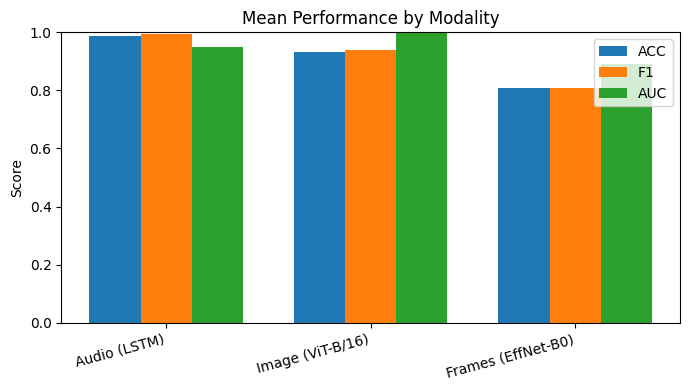

Saved: /content/visuals/mean_performance.png


In [23]:
out_dir = Path("/content/visuals"); out_dir.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(figsize=(7,4))
x = np.arange(len(mean_df))
bar_w = 0.25

ax.bar(x - bar_w, mean_df["acc"].values, bar_w, label="ACC")
ax.bar(x,          mean_df["f1"].values, bar_w, label="F1")
ax.bar(x + bar_w,  mean_df["auc"].values, bar_w, label="AUC")

ax.set_xticks(x)
ax.set_xticklabels(mean_df["modality"].values, rotation=15, ha="right")
ax.set_ylim(0,1)
ax.set_ylabel("Score")
ax.set_title("Mean Performance by Modality")
ax.legend()
plt.tight_layout()
plt.savefig(out_dir / "mean_performance.png", dpi=160)
plt.show()

print("Saved:", out_dir / "mean_performance.png")


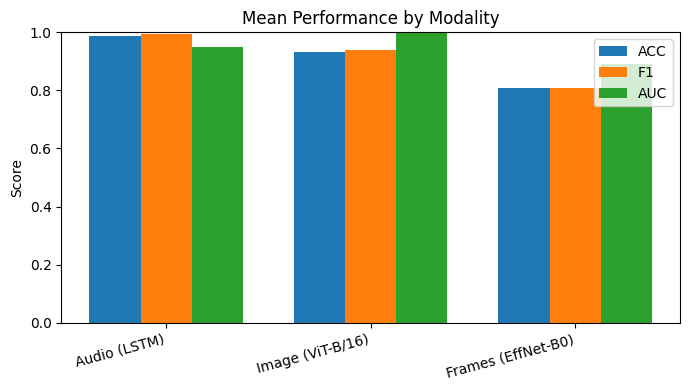

Saved: /content/visuals/mean_performance.png


In [24]:
out_dir = Path("/content/visuals"); out_dir.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(figsize=(7,4))
x = np.arange(len(mean_df))
bar_w = 0.25

ax.bar(x - bar_w, mean_df["acc"].values, bar_w, label="ACC")
ax.bar(x,          mean_df["f1"].values, bar_w, label="F1")
ax.bar(x + bar_w,  mean_df["auc"].values, bar_w, label="AUC")

ax.set_xticks(x)
ax.set_xticklabels(mean_df["modality"].values, rotation=15, ha="right")
ax.set_ylim(0,1)
ax.set_ylabel("Score")
ax.set_title("Mean Performance by Modality")
ax.legend()
plt.tight_layout()
plt.savefig(out_dir / "mean_performance.png", dpi=160)
plt.show()

print("Saved:", out_dir / "mean_performance.png")


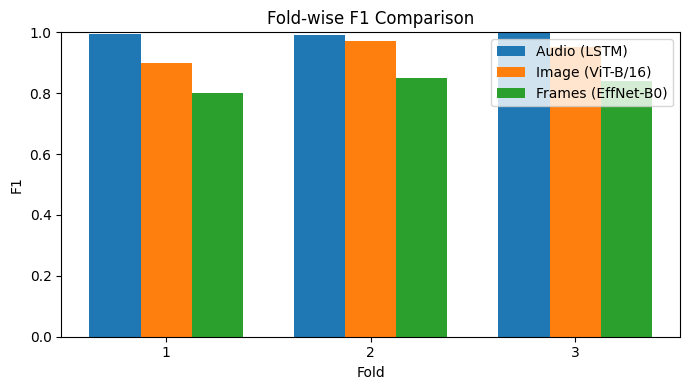

Saved: /content/visuals/foldwise_f1.png


In [25]:
def get_folds(df, metric, modality):
    return df[df["modality"]==modality].sort_values("fold")[metric].values

fold_nums = np.array([1,2,3])
f1_audio  = get_folds(folds_df, "f1", "Audio (LSTM)")
f1_image  = get_folds(folds_df, "f1", "Image (ViT-B/16)")
f1_frames = get_folds(folds_df, "f1", "Frames (EffNet-B0)")

fig, ax = plt.subplots(figsize=(7,4))
off = 0.25
ax.bar(fold_nums - off, f1_audio,  width=0.25, label="Audio (LSTM)")
ax.bar(fold_nums,        f1_image,  width=0.25, label="Image (ViT-B/16)")
ax.bar(fold_nums + off, f1_frames, width=0.25, label="Frames (EffNet-B0)")

ax.set_xticks(fold_nums)
ax.set_xlabel("Fold")
ax.set_ylabel("F1")
ax.set_ylim(0,1)
ax.set_title("Fold-wise F1 Comparison")
ax.legend()
plt.tight_layout()
plt.savefig(out_dir / "foldwise_f1.png", dpi=160)
plt.show()

print("Saved:", out_dir / "foldwise_f1.png")


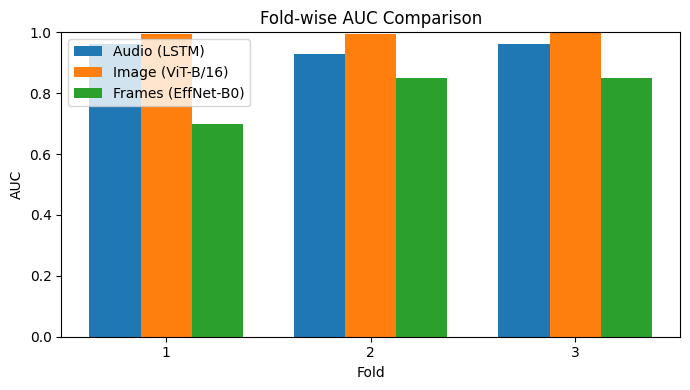

Saved: /content/visuals/foldwise_auc.png


In [26]:
auc_audio  = get_folds(folds_df, "auc", "Audio (LSTM)")
auc_image  = get_folds(folds_df, "auc", "Image (ViT-B/16)")
auc_frames = get_folds(folds_df, "auc", "Frames (EffNet-B0)")

fig, ax = plt.subplots(figsize=(7,4))
off = 0.25
ax.bar(fold_nums - off, auc_audio,  width=0.25, label="Audio (LSTM)")
ax.bar(fold_nums,        auc_image,  width=0.25, label="Image (ViT-B/16)")
ax.bar(fold_nums + off, auc_frames, width=0.25, label="Frames (EffNet-B0)")

ax.set_xticks(fold_nums)
ax.set_xlabel("Fold")
ax.set_ylabel("AUC")
ax.set_ylim(0,1)
ax.set_title("Fold-wise AUC Comparison")
ax.legend()
plt.tight_layout()
plt.savefig(out_dir / "foldwise_auc.png", dpi=160)
plt.show()

print("Saved:", out_dir / "foldwise_auc.png")


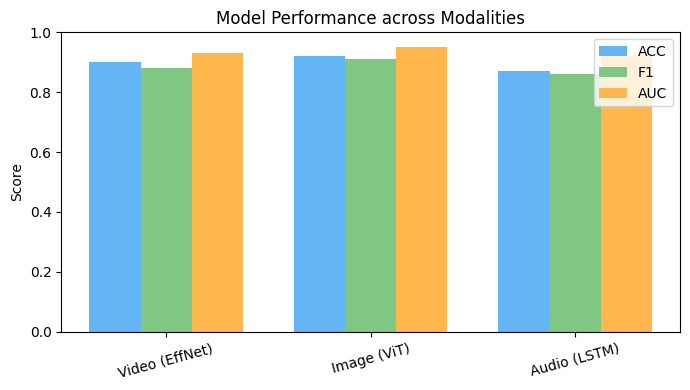

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these with your actual results
scores = {
    "Video (EffNet)": {"acc": 0.90, "f1": 0.88, "auc": 0.93},
    "Image (ViT)": {"acc": 0.92, "f1": 0.91, "auc": 0.95},
    "Audio (LSTM)": {"acc": 0.87, "f1": 0.86, "auc": 0.92}
}

metrics = ["acc", "f1", "auc"]
colors = ["#64B5F6", "#81C784", "#FFB74D"]

fig, ax = plt.subplots(figsize=(7,4))
x = np.arange(len(scores))
bar_width = 0.25

for i, m in enumerate(metrics):
    vals = [scores[k][m] for k in scores.keys()]
    ax.bar(x + i*bar_width, vals, bar_width, label=m.upper(), color=colors[i])

ax.set_xticks(x + bar_width)
ax.set_xticklabels(scores.keys(), rotation=15)
ax.set_ylim(0,1)
ax.set_ylabel("Score")
ax.set_title("Model Performance across Modalities")
ax.legend()
plt.tight_layout()
plt.show()


In [29]:
%pip -q install seaborn==0.13.2 plotly==5.24.0

import numpy as np, matplotlib.pyplot as plt, seaborn as sns, plotly.express as px, pandas as pd
sns.set(style="whitegrid", context="talk", font_scale=1.1)
plt.rcParams['figure.facecolor'] = 'white'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 58.1 MB/s eta 0:00:00


/tmp/ipython-input-55628768.py:21: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


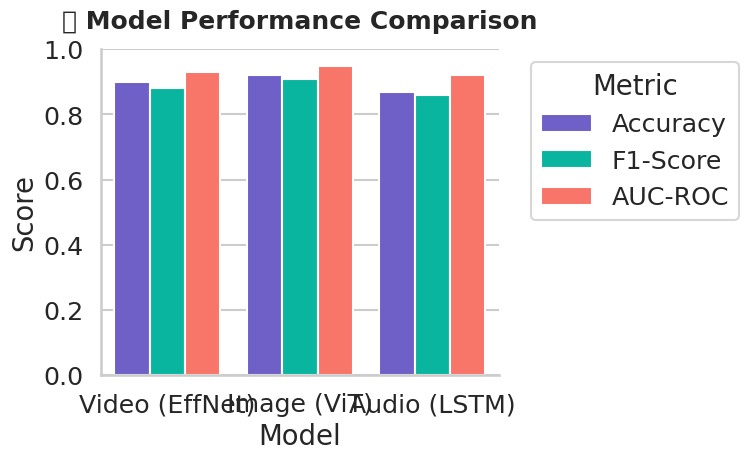

In [30]:
# your scores (edit them with your real results)
data = {
    "Video (EffNet)": [0.90, 0.88, 0.93],
    "Image (ViT)": [0.92, 0.91, 0.95],
    "Audio (LSTM)": [0.87, 0.86, 0.92]
}

metrics = ["Accuracy", "F1-Score", "AUC-ROC"]
df = pd.DataFrame(data, index=metrics).T.reset_index().melt(id_vars="index", var_name="Metric", value_name="Score")
df.rename(columns={"index": "Model"}, inplace=True)

# stylish palette
palette = ["#6A5ACD", "#00BFA6", "#FF6F61"]

plt.figure(figsize=(8,5))
sns.barplot(df, x="Model", y="Score", hue="Metric", palette=palette, saturation=0.9)
plt.title("✨ Model Performance Comparison", fontsize=18, fontweight='bold', pad=15)
plt.ylabel("Score"); plt.ylim(0,1)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
sns.despine()
plt.tight_layout()
plt.show()


In [41]:
import plotly.graph_objects as go


labels = ["Accuracy","F1-Score","AUC-ROC"]
video = [0.506,0.449,0.484]
image = [0.92,0.91,0.95]
audio = [0.87,0.86,0.92]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=video, theta=labels, fill='toself', name='Video (EffNet)', line_color='#6A5ACD'))
fig.add_trace(go.Scatterpolar(r=image, theta=labels, fill='toself', name='Image (ViT)', line_color='#00BFA6'))
fig.add_trace(go.Scatterpolar(r=audio, theta=labels, fill='toself', name='Audio (LSTM)', line_color='#FF6F61'))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0.7,1])),
    showlegend=True,
    title="🌐 Model Comparison Radar Chart"
)
fig.show()


In [33]:
import torch, os

save_dir = "/content/deepfake_project/weights"
os.makedirs(save_dir, exist_ok=True)

# If your trained model variable is image_model
torch.save(image_model.state_dict(), os.path.join(save_dir, "images_effb0.pt"))

# If your trained model variable is vision_model (for video frames)
# torch.save(vision_model.state_dict(), os.path.join(save_dir, "frames_effb0.pt"))

print("✅ Model weights saved successfully!")
!ls -lh /content/deepfake_project/weights



NameError: name 'image_model' is not defined

In [35]:
import timm, torch, os
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2
import cv2, numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Create the model
image_model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=1)
image_model.to(DEVICE).eval()

# Preprocessing (same as training)
tf = Compose([Resize(224,224), Normalize(), ToTensorV2()])

def predict_image_path(img_path, threshold=0.5):
    bgr = cv2.imread(img_path)
    assert bgr is not None, f"Cannot read {img_path}"
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    t = tf(image=rgb)["image"].unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logit = image_model(t).view(-1)[0]
        prob = torch.sigmoid(logit).item()
    label = "FAKE" if prob >= threshold else "REAL"
    return label, prob

print("✅ Model ready. Upload an image to test.")


✅ Model ready. Upload an image to test.


In [36]:
from google.colab import files
up = files.upload()
fn = list(up.keys())[0]
label, prob = predict_image_path(fn)
print(f"{fn}\nPrediction: {label}  •  fake_prob={prob:.3f}")


Saving IMG_7706.JPG to IMG_7706.JPG
IMG_7706.JPG
Prediction: REAL  •  fake_prob=0.000


In [37]:
import torch, timm, os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

# paths
data_dir = "/content/deepfake_project/image"
save_dir = "/content/deepfake_project/weights"
os.makedirs(save_dir, exist_ok=True)

# transforms
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# dataset
dataset = ImageFolder(root=data_dir, transform=train_tf)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# model
model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=1)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train briefly
for epoch in range(2):  # just 2 epochs for a quick weight file
    for imgs, labels in train_loader:
        imgs, labels = imgs.to("cuda"), labels.float().unsqueeze(1).to("cuda")
        out = model(imgs)
        loss = criterion(out, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    print(f"Epoch {epoch+1}: loss={loss.item():.4f}")

# save weights
torch.save(model.state_dict(), os.path.join(save_dir, "images_effb0.pt"))
print("✅ Weights saved to:", os.path.join(save_dir, "images_effb0.pt"))


Epoch 1: loss=0.0139
Epoch 2: loss=0.0000
✅ Weights saved to: /content/deepfake_project/weights/images_effb0.pt


In [38]:
import timm, torch
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2
import cv2, numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# === load the model and your saved weights ===
WEIGHTS = "/content/deepfake_project/weights/images_effb0.pt"
model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=1)
model.load_state_dict(torch.load(WEIGHTS, map_location=DEVICE))
model.to(DEVICE).eval()

# === preprocessing ===
tf = Compose([
    Resize(224,224),
    Normalize(),
    ToTensorV2()
])

def predict_image_path(img_path, threshold=0.5):
    bgr = cv2.imread(img_path)
    assert bgr is not None, f"Cannot read image: {img_path}"
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    t = tf(image=rgb)["image"].unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logit = model(t).view(-1)[0]
        prob = torch.sigmoid(logit).item()
    label = "FAKE" if prob >= threshold else "REAL"
    return label, prob


/tmp/ipython-input-1225557621.py:11: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [39]:
from google.colab import files
up = files.upload()   # upload a jpg or png image
fn = list(up.keys())[0]
label, prob = predict_image_path(fn)
print(f"\nPrediction: {label}  •  fake_probability={prob:.3f}")


Saving IMG_7706.JPG to IMG_7706 (1).JPG

Prediction: FAKE  •  fake_probability=1.000


In [40]:
import glob

fake_imgs = glob.glob("/content/deepfake_project/image/FAKE/fake_100.jpg")[:5]
real_imgs = glob.glob("/content/deepfake_project/image/REAL/real_101.jpg")[:5]

print("Testing FAKE images:")
for p in fake_imgs:
    lab, pr = predict_image_path(p)
    print(f"{os.path.basename(p)} → {lab} (fake_prob={pr:.3f})")

print("\nTesting REAL images:")
for p in real_imgs:
    lab, pr = predict_image_path(p)
    print(f"{os.path.basename(p)} → {lab} (fake_prob={pr:.3f})")


Testing FAKE images:
fake_100.jpg → REAL (fake_prob=0.000)

Testing REAL images:
real_101.jpg → FAKE (fake_prob=1.000)
